# Secondary Electron Population Fit
Other extreme, assume no primary electrons present
- Fit Secondary electron synchrotron result to Coma Data
- Find new index and norm
- Find ratio to thermal energy

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=True, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                 __  __ ___ ___   _   ___   ___                 
                |  \/  |_ _/ __| /_\ |   \ / _ \                
                | |\/| || | (__ / _ \| |) | (_) |               
                |_|  |_|___\___/_/ \_\___/ \___/                
 Modeling the Intra Cluster Atmosphere for Diverse Observations 
----------------------------------------------------------------
                                                                
Setting gNFW Planck coll. (2013) UPP.


In [31]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm


clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

Eemin = (const.m_e *const.c**2).to('GeV')
#clust.Epmin 
Eemax = clust.Epmax

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting spectrum_cre1_model value
Setting density_cre1_model value
Fixing: R500
Getting the maximal proton energy


In [7]:
def sync_spectrum( freq = np.logspace(-3,2,100)*u.GHz, norm = 1 , ind = 2.3 ):
    
    '''Uses Primary Electron population via rate_sync() and multiplies the result by the norm
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
    clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':ind }


    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = rate_sync(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')


def sync_spectrum2( freq = np.logspace(-3,2,100)*u.GHz, norm = 1  , ind = 2.3 ):
    
    '''Uses the Secondary Electron population
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
  
    
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = clust.get_rate_synchrotron(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')

## Compare Automatic Function and Default values

Setting spectrum_crp_model value


Text(0.5,1,'new')

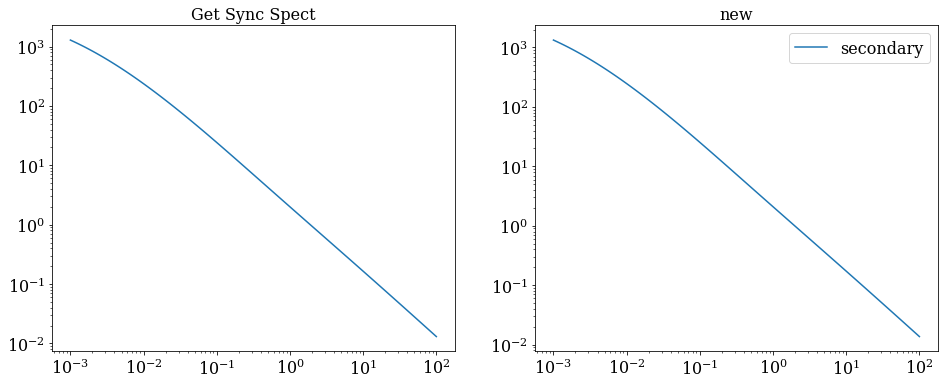

In [8]:
plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Get Sync Spect")

#New one 
plt.subplot(122)
frequency, spectrum2 = sync_spectrum2()
plt.loglog(frequency, spectrum2, label = "secondary")
plt.legend()

plt.title("new")


# Coma

In [9]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

In [10]:
from scipy import optimize

dat_freq = dat_freq.to('GHz')


clust._Npt_per_decade_integ = 5
## Sync Spectrum will be identical to the one from "electrons", but with norm as a parameter
## SyncFit , norm set 


def syncfit(x,a, b):
    return sync_spectrum2(x*u.GHz,a, b)[1].to_value('Jy')



params, params_covariance = optimize.curve_fit(syncfit, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0, 2])

print(params)

Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting spectrum_crp_model value
Setting sp

Setting spectrum_crp_model value


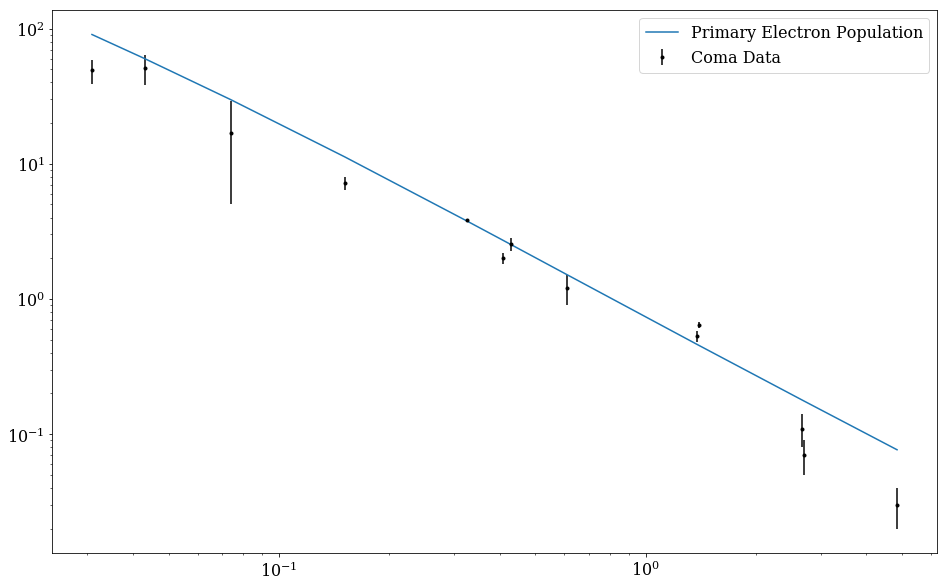

In [11]:
plt.figure(figsize=(15, 10))
plt.errorbar(dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), yerr = dat_err.to_value('Jy') , fmt="k.", label = "Coma Data")
#plt.scatter(dat_freq, dat_flux, label='Data')
plt.loglog(dat_freq, syncfit(dat_freq.to_value('GHz'), params[0],params[1]),
         label='Primary Electron Population')

plt.legend(loc='best')

plt.show()

## Look at new Ratio

In [21]:
## Change index
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index': params[1]}

Setting spectrum_crp_model value


In [28]:
## Change norm § but I'm not so sure if this works as I intended

def cre2_spectrum( energy=np.logspace(-2,7,100)*u.GeV, Rmax=None):

        # In case the input is not an array
        energy = model_tools.check_qarray(energy, unit='GeV')

        # Define the radius for integration
        if Rmax is None:
            Rmax = clust.R500
                
        # Integrate over the considered volume
        rmin = np.amin([clust.Rmin.to_value('kpc'), Rmax.to_value('kpc')/10])*u.kpc #In case of small Rmax, make sure we go low enough
        rad = model_tools.sampling_array(rmin, Rmax, NptPd=clust._Npt_per_decade_integ, unit=True)

        # To improve precision around R_truncation in integration
        if np.amax(rad) > clust.R_truncation:
            rad = rad.insert(0, clust.R_truncation)
            rad.sort()

        # Get the differential spectrum/profile
        dN_dEdV = clust.get_cre2_2d(energy, rad)

        # Integrate
        spectrum = model_tools.trapz_loglog(4*np.pi*rad**2 * params[0]*dN_dEdV, rad)

        return energy, spectrum.to('GeV-1')
    
    
    
def crp_spectrum( energy=np.logspace(-2,7,100)*u.GeV, Rmax=None):

        # In case the input is not an array
        energy = model_tools.check_qarray(energy, unit='GeV')

        # Define the radius for integration
        if Rmax is None:
            Rmax = clust.R500
                
        # Integrate over the considered volume
        rmin = np.amin([clust.Rmin.to_value('kpc'), Rmax.to_value('kpc')/10])*u.kpc #In case of small Rmax, make sure we go low enough
        rad = model_tools.sampling_array(rmin, Rmax, NptPd=clust._Npt_per_decade_integ, unit=True)

        # To improve precision around R_truncation in integration
        if np.amax(rad) > clust.R_truncation:
            rad = rad.insert(0, clust.R_truncation)
            rad.sort()

        # Get the differential spectrum/profile
        dN_dEdV = clust.get_crp_2d(energy, rad)

        # Integrate
        spectrum = model_tools.trapz_loglog(4*np.pi*rad**2 * params[0]*dN_dEdV, rad)

        return energy, spectrum.to('GeV-1')
    

## Secondary Electron Energy

In [23]:
#Energy in spectrum
eng = model_tools.sampling_array(Eemin , Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)

#eng, Fe = get_normed_spectrum_cre1(clust, eng)
#Integ_e = model_tools.trapz_loglog( eng* Fe.to_value('adu'), eng)


eng, Fe = cre2_spectrum(eng)
Integ_e2 = model_tools.trapz_loglog( eng* Fe, eng)
Integ_e2

Getting R500 value
Getting Rmin value
Getting R_truncation value


<Quantity 1.3705652e+61 GeV>

## CRp Energy

In [29]:
eng = model_tools.sampling_array(Eemin , Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)

#eng, Fe = get_normed_spectrum_cre1(clust, eng)
#Integ_e = model_tools.trapz_loglog( eng* Fe.to_value('adu'), eng)


eng, Fp = crp_spectrum(eng)
Integ_p = model_tools.trapz_loglog( eng* Fp, eng)
Integ_p

Getting R500 value
Getting Rmin value
Getting R_truncation value


<Quantity 3.74784496e+64 GeV>

### Thermal Energy

In [24]:
# Thermal energy
rad, ene = clust.get_thermal_energy_profile(clust.R500)
ene = ene.to('GeV')
ene

Getting R500 value


<Quantity [1.76547987e+66] GeV>

# Energy Ratio

In [30]:
# Secondary Electrons
X_cre2_E = float(Integ_e2/ene)
X_crp_E = float(Integ_p/ene)
print "For 2ndary electrons it is ",X_cre2_E
print "For protons it is ", X_crp_E

For 2ndary electrons it is  7.76313125174e-06
For protons it is  0.0212284774382


# More Direct version



In [36]:
%%time
clust.X_crp_E


Getting the cosmic ray protons / thermal energy and normalization radius
CPU times: user 95 µs, sys: 0 ns, total: 95 µs
Wall time: 99.9 µs


{'R_norm': <Quantity 1369.4682155 kpc>, 'X': 0.005687649485602653}

In [37]:
%%time
from scipy import optimize

dat_freq = dat_freq.to('GHz')



## Sync Spectrum will be identical to the one from "electrons", but with norm as a parameter
## SyncFit , norm set 


def syncfit(x,a, ind):
    clust.X_crp_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')





params, params_covariance = optimize.curve_fit(syncfit, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print(params)

Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Set